# Phase 2 - Muliticlass classifier to predict death time for in-hospital mortality


In [1]:
import pandas as pd
import numpy as np
from scipy import interp
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
Imputer = SimpleImputer(missing_values=np.nan, strategy='median') # mean median.
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import *
import sklearn.multiclass
from itertools import cycle
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({'font.size': 12})

---
## Part 1. Define classes and methods for the machine learning pipieline


In [2]:
unseen_label = "__New__"
seed = 200

class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.le = LabelEncoder()
        self.lb = LabelBinarizer()
        self.seen_labels = set()
        
    def fit(self, x, y=None,**fit_params):
        self.seen_labels = set(x)
        self.seen_labels.add(unseen_label)
        
        # add "unseen" to X
        x_new = list(x)
        x_new.append(unseen_label)

        label_encoded = self.le.fit_transform(x_new)
        self.lb.fit(label_encoded)
        return self
    
    def transform(self, x):
        x_new = list(map(lambda label: label if label in self.seen_labels else unseen_label, list(x)))
        label_encoded = self.le.transform(x_new)
        return self.lb.transform(label_encoded)
    
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key]

    
class MultiItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key_list):
        self.key_list = key_list

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key_list]

In [3]:
def descretize(x, cutoff1, cutoff2):
    if x < cutoff1:
        return 0
    elif x < cutoff2:
        return 1
    else: 
        return 2

def evaluate(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1score_micro = f1_score(y_true, y_pred, average='micro')   
    f1score_macro = f1_score(y_true, y_pred, average='macro')  
    print ("Accuracy : {:.4f}".format(acc))
    print("Precision (Micro) : {:.4f}".format(precision_micro))
    print("Precision (Macro): {:.4f}".format(precision_macro))
    print("Recall (Micro) : {:.4f}".format(recall_micro))
    print("Recall (Macro): {:.4f}".format(recall_macro))
    print("F1 score (Micro) : {:.4f}".format(f1score_micro))
    print("F1 score (Macro): {:.4f}".format(f1score_macro))
    print("\nClassification report : \n", classification_report(y_true, y_pred))
    print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))

In [4]:
def train_evaluate_model(df):
    # set cutoff for multiclass labels
    cutoff1 = 24
    cutoff2 = 24*7
    
    # filter out ICU stays with negative death time
    # so that our model will train on dead patients with death time >= 0
    df_dead = df[(df.hospital_expire_flag==1) & (df.hosp_deathtime_hours>=0)]
    print(df.shape, df_dead.shape)
    
    # split data into 80% training set, 20% test set
    train_cv_df = df_dead.sample(frac=0.8,random_state=seed)
    test_df = df_dead.drop(train_cv_df.index)
    print('Train-test split: ', train_cv_df.shape, test_df.shape)
    
    # define the machine learning pipeline
    discrete_pipeline = Pipeline([
        ("feature_union", FeatureUnion(
            transformer_list=[
                # categorical pipeline
                ('ethnicity', Pipeline([
                    ("selector", ItemSelector(key='ethnicity')),
                    ("binarizer", CustomLabelBinarizer())
                ])),            

                ("gender", Pipeline([
                    ("selector", ItemSelector(key='gender')),
                    ("binarizer", CustomLabelBinarizer())
                ])),
                ("admission_type", Pipeline([
                    ("selector", ItemSelector(key='admission_type')),
                    ("binarizer", CustomLabelBinarizer())
                ])),

                # numerical pipeline
                ("numerical", Pipeline([
                    ("selector", MultiItemSelector(key_list=
                          ['age', 'icustay_num',
                           'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
                           'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean', 
                           'heartrate_min', 'sysbp_min', 'diasbp_min','meanbp_min', 
                           'resprate_min', 'tempc_min', 'spo2_min', 'glucose_min',
                           'heartrate_max', 'sysbp_max', 'diasbp_max', 'meanbp_max',
                           'resprate_max', 'tempc_max', 'spo2_max', 'glucose_max', 
                           'gcs_mean', 'gcsmotor_mean', 'gcsverbal_mean', 'gcseyes_mean', 'endotrachflag_mean',
                           'gcs_min', 'gcsmotor_min', 'gcsverbal_min', 'gcseyes_min', 'endotrachflag_min', 
                           'gcs_max', 'gcsmotor_max', 'gcsverbal_max', 'gcseyes_max', 'endotrachflag_max', 
                           'baseexcess_mean', 'carboxyhemoglobin_mean', 'methemoglobin_mean', 
                           'po2_mean', 'pco2_mean', 'ph_mean', 'pao2fio2ratio_mean', 'totalco2_mean', 
                           'aniongap_mean', 'albumin_mean', 'bands_mean', 'bicarbonate_mean', 
                           'bilirubin_mean', 'calcium_mean', 'creatinine_mean', 'chloride_mean', 
                           'hematocrit_mean', 'hemoglobin_mean', 'lactate_mean', 'platelet_mean', 
                           'potassium_mean', 'ptt_mean', 'inr_mean', 'sodium_mean', 'bun_mean', 'wbc_mean',
                           'baseexcess_min', 'carboxyhemoglobin_min', 'methemoglobin_min',
                           'po2_min', 'pco2_min', 'ph_min', 'pao2fio2ratio_min', 'totalco2_min',
                           'aniongap_min', 'albumin_min', 'bands_min', 'bicarbonate_min',
                           'bilirubin_min', 'calcium_min', 'creatinine_min', 'chloride_min',
                           'hematocrit_min', 'hemoglobin_min', 'lactate_min', 'platelet_min',
                           'potassium_min', 'ptt_min', 'inr_min', 'sodium_min', 'bun_min', 'wbc_min', 
                           'baseexcess_max', 'carboxyhemoglobin_max', 'methemoglobin_max', 
                           'po2_max', 'pco2_max', 'ph_max', 'pao2fio2ratio_max', 'totalco2_max',          
                           'aniongap_max', 'albumin_max', 'bands_max', 'bicarbonate_max', 
                           'bilirubin_max', 'calcium_max', 'creatinine_max', 'chloride_max', 
                           'hematocrit_max', 'hemoglobin_max', 'lactate_max', 'platelet_max', 
                           'potassium_max', 'ptt_max', 'inr_max', 'sodium_max', 'bun_max', 'wbc_max', 
                           'urineoutput'])),
                    # impute missing values with median
                    #("imputer", Imputer(strategy="median",axis=0)),
                    ("imputer", SimpleImputer(missing_values=np.nan, strategy='median')),                    
                    
                ]))

            ]
        )),
        ("algorithm", XGBClassifier(n_jobs=-1))
    ])

    # define the parameter grid
#    parameters = {'algorithm__n_estimators': [100, 250, 500],
#                  'algorithm__max_features': ["auto", "sqrt", "log2"],
#                  "algorithm__criterion": ["gini", "entropy"],
#                  "algorithm__max_depth": [5, 10, 30],
#                  "algorithm__bootstrap": [True, False]}
    
    parameters = {'algorithm__n_estimators': [500],
                  'algorithm__max_features': ["auto"],
                  "algorithm__criterion": ["gini", "entropy"],
                  "algorithm__max_depth": [30],
                  "algorithm__bootstrap": [True]}
    
    # grid search on 5-fold CV, trained on 80% training set
    # note that we have also transformed hosp_deathtime_hours to 3 classes using descretize()
    grid_search = GridSearchCV(discrete_pipeline, parameters, n_jobs=-1, verbose=1, refit=True, cv=5, scoring='f1_micro')
    grid_search.fit(train_cv_df, train_cv_df.hosp_deathtime_hours.map(lambda x: descretize(x, cutoff1, cutoff2)))

    # retrieve the best parameter set from grid search
    print("\nGrid Search Best parameters set :")
    print(grid_search.best_params_)
    print("\nBest score: %0.3f" % grid_search.best_score_)
    
    # print test score on each fit
#     print("\nGrid scores :")
#     means = grid_search.cv_results_['mean_test_score']
#     stds = grid_search.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds,grid_search.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    
    # evaluate model performance
    print("\nEvaluation on Test Set (20%) :")
    test_actual = test_df.hosp_deathtime_hours.map(lambda x: descretize(x, cutoff1, cutoff2))
    test_pred = grid_search.predict(test_df)
    evaluate(test_actual, test_pred)
    
    # compute prediction proba (y_score) and actual label (y_test) on test set
    # they will be used for plotting ROC curves later
    ohc = OneHotEncoder()
    y_test = ohc.fit_transform(test_actual.values.reshape(-1,1)).todense()
    y_score = grid_search.predict_proba(test_df)
    print(y_test.shape, y_score.shape)
    
    return grid_search, y_test, y_score

---
## Part 2. Model training and evaluation using 1-day, 2-day, 3-day data


In [5]:
# load 1-day, 2-day and 3-day data extracted previously using Hive
df_6hr = pd.read_csv('../../data/mp_data_1day.csv')
df_12hr = pd.read_csv('../../data/mp_data_2day.csv')
df_24hr = pd.read_csv('../../data/mp_data_3day.csv')

print(df_6hr.shape, df_12hr.shape, df_24hr.shape)
df_6hr.head()

(49632, 131) (49632, 131) (49632, 131)


,subject_id,hadm_id,icustay_id,dbsource,expire_flag,hospital_expire_flag,deathtime_hours,hosp_deathtime_hours,age,gender,...,hemoglobin_max,lactate_max,platelet_max,potassium_max,ptt_max,inr_max,sodium_max,bun_max,wbc_max,urineoutput
0,3,145834,211552,carevue,1,0,5669.0,NaN,76.5246,M,...,10.1,8.0,359.0,4.4,52.35,1.7,141.5,42.0,24.4,497.0
1,4,185777,294638,carevue,0,0,NaN,NaN,47.8450,F,...,10.6,NaN,201.0,3.3,33.20,1.1,141.0,10.0,9.7,2150.0
2,6,107064,228232,carevue,0,0,NaN,NaN,65.9398,F,...,9.2,NaN,330.0,4.8,41.20,1.1,134.0,65.0,10.6,1940.0
3,9,150750,220597,carevue,1,1,107.0,118.0,41.7887,M,...,14.0,2.7,249.0,3.0,NaN,NaN,138.0,17.0,13.7,1987.0
4,11,194540,229441,carevue,1,0,5082.0,NaN,50.1476,F,...,12.6,NaN,258.0,3.9,NaN,NaN,142.0,19.0,12.8,1050.0


In [6]:
# fit the pipeline using 1-day data
grid_search_6hr, y_test_6hr, y_score_6hr = train_evaluate_model(df_6hr)

(49632, 131) (5718, 131)
Train-test split:  (4574, 131) (1144, 131)
Fitting 5 folds for each of 2 candidates, totalling 10 fits


D:\software\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bootstrap, criterion, max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Grid Search Best parameters set :
{'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 30, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}

Best score: 0.601

Evaluation on Test Set (20%) :
Accuracy : 0.6136
Precision (Micr

In [7]:
# fit the pipeline using 2-day data
grid_search_12hr, y_test_12hr, y_score_12hr = train_evaluate_model(df_12hr)

(49632, 131) (5718, 131)
Train-test split:  (4574, 131) (1144, 131)
Fitting 5 folds for each of 2 candidates, totalling 10 fits


D:\software\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:19:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bootstrap, criterion, max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:19:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Grid Search Best parameters set :
{'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 30, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}

Best score: 0.653

Evaluation on Test Set (20%) :
Accuracy : 0.6530
Precision (Micr

In [8]:
# fit the pipeline using 3-day data
grid_search_124hr, y_test_24hr, y_score_24hr = train_evaluate_model(df_24hr)

(49632, 131) (5718, 131)
Train-test split:  (4574, 131) (1144, 131)
Fitting 5 folds for each of 2 candidates, totalling 10 fits


D:\software\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:20:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bootstrap, criterion, max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:20:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Grid Search Best parameters set :
{'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 30, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}

Best score: 0.683

Evaluation on Test Set (20%) :
Accuracy : 0.6862
Precision (Micr

---
## Part 3. Visualization of ROC curves


In [9]:
def plot_roc(y_test, y_score, plot_title, filepath) :
    
    # compute fpr, tpr and auc for each class respectively
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # compute micro-average fpr, tpr and auc
    fpr["micro"], tpr["micro"], _ = roc_curve(np.array(y_test).ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
   # compute macro-average fpr, tpr and auc
    n_classes = 3
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # plot all ROC curves
    lw = 2
    fig = plt.figure()
    fig.set_size_inches(8,7)
    plt.plot(fpr["micro"], tpr["micro"],\
             label='micro-average ROC curve (area = {0:0.2f})'\
             ''.format(roc_auc["micro"]),\
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],\
             label='macro-average ROC curve (area = {0:0.2f})'\
                   ''.format(roc_auc["macro"]),\
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,\
                 label='ROC curve of class {0} (area = {1:0.2f})'\
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend(loc="lower right")
    fig.savefig(filepath)
    plt.show()

<ipython-input-9-5f417e828be1>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


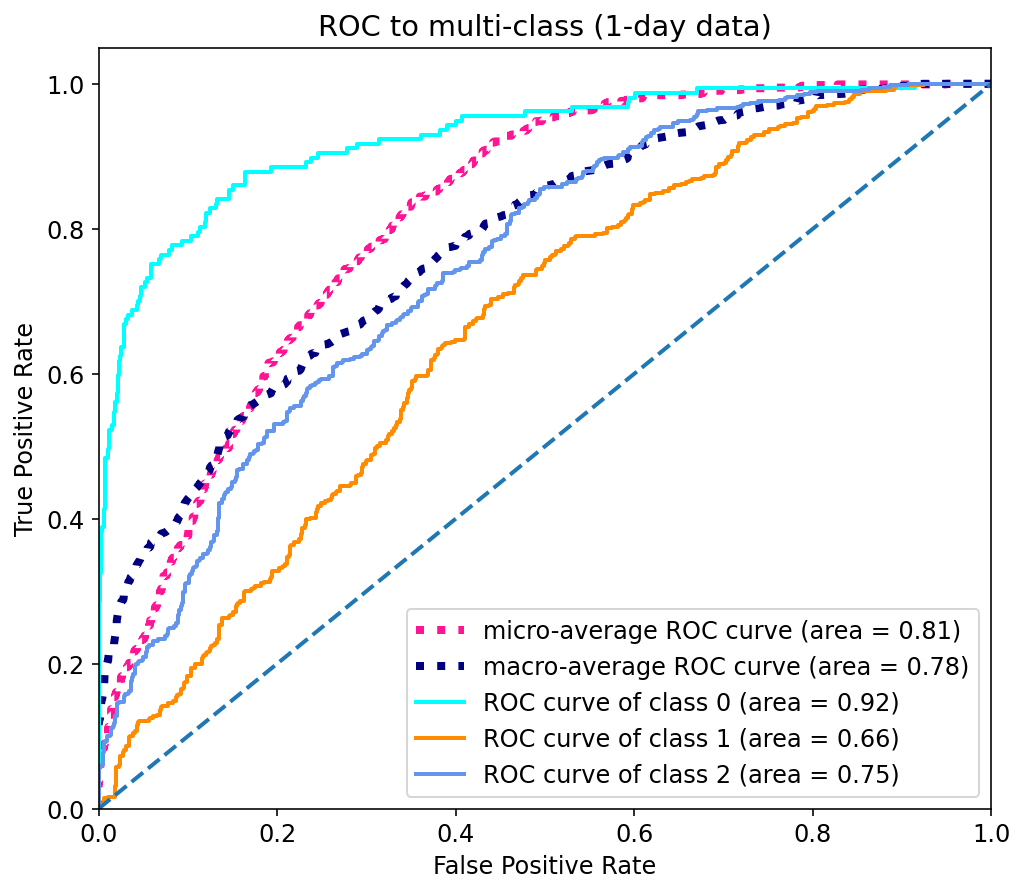

In [10]:
# plot ROC curves for 1-day data
plot_roc(y_test_6hr, y_score_6hr, 
         plot_title='ROC to multi-class (1-day data)', filepath='../img/figure3.png')

<ipython-input-9-5f417e828be1>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


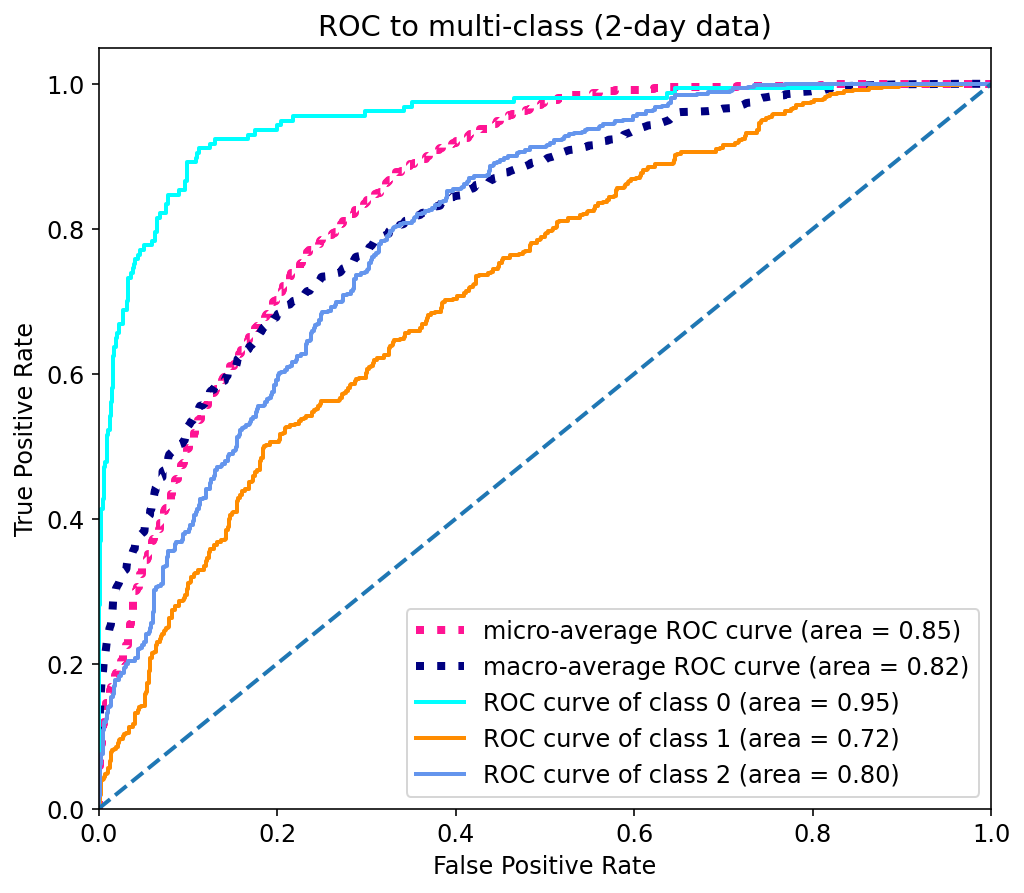

In [11]:
# plot ROC curves for 2-day data
plot_roc(y_test_12hr, y_score_12hr, 
         plot_title='ROC to multi-class (2-day data)', filepath='../img/figure4.png')

<ipython-input-9-5f417e828be1>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


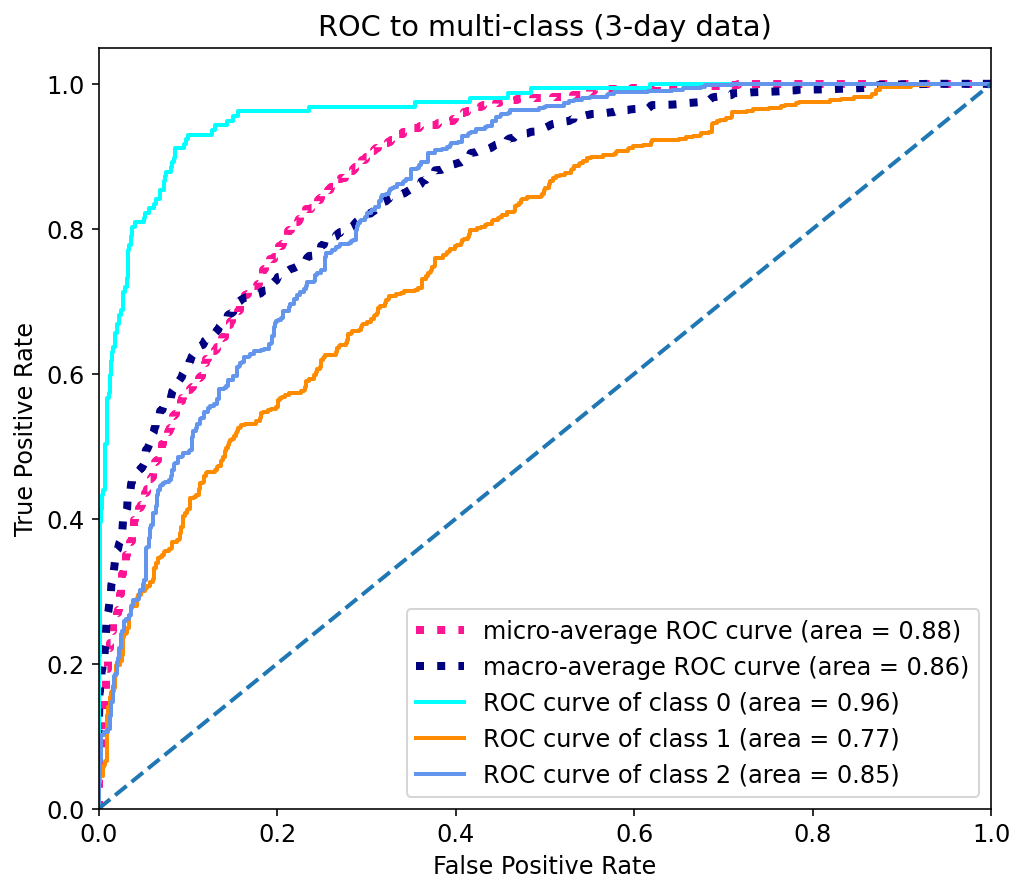

In [12]:
# plot ROC curves for 3-day data
plot_roc(y_test_24hr, y_score_24hr, 
         plot_title='ROC to multi-class (3-day data)', filepath='../img/figure5.png')

---
## Part 4. Visualization of Feature Importance


In [13]:
# show best parameter resulted from grid search
grid_search_6hr.best_params_

{'algorithm__bootstrap': True,
 'algorithm__criterion': 'gini',
 'algorithm__max_depth': 30,
 'algorithm__max_features': 'auto',
 'algorithm__n_estimators': 500}

In [14]:
# load data
df_6hr = pd.read_csv('../../data/mp_data_1day.csv')

# define features
categorical_features = ['gender', 'ethnicity', 'admission_type']
numerical_features = ['age', 'icustay_num',
                       'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
                       'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean', 
                       'heartrate_min', 'sysbp_min', 'diasbp_min','meanbp_min', 
                       'resprate_min', 'tempc_min', 'spo2_min', 'glucose_min',
                       'heartrate_max', 'sysbp_max', 'diasbp_max', 'meanbp_max',
                       'resprate_max', 'tempc_max', 'spo2_max', 'glucose_max', 
                       'gcs_mean', 'gcsmotor_mean', 'gcsverbal_mean', 'gcseyes_mean', 'endotrachflag_mean',
                       'gcs_min', 'gcsmotor_min', 'gcsverbal_min', 'gcseyes_min', 'endotrachflag_min', 
                       'gcs_max', 'gcsmotor_max', 'gcsverbal_max', 'gcseyes_max', 'endotrachflag_max', 
                       'baseexcess_mean', 'carboxyhemoglobin_mean', 'methemoglobin_mean', 
                       'po2_mean', 'pco2_mean', 'ph_mean', 'pao2fio2ratio_mean', 'totalco2_mean', 
                       'aniongap_mean', 'albumin_mean', 'bands_mean', 'bicarbonate_mean', 
                       'bilirubin_mean', 'calcium_mean', 'creatinine_mean', 'chloride_mean', 
                       'hematocrit_mean', 'hemoglobin_mean', 'lactate_mean', 'platelet_mean', 
                       'potassium_mean', 'ptt_mean', 'inr_mean', 'sodium_mean', 'bun_mean', 'wbc_mean',
                       'baseexcess_min', 'carboxyhemoglobin_min', 'methemoglobin_min',
                       'po2_min', 'pco2_min', 'ph_min', 'pao2fio2ratio_min', 'totalco2_min',
                       'aniongap_min', 'albumin_min', 'bands_min', 'bicarbonate_min',
                       'bilirubin_min', 'calcium_min', 'creatinine_min', 'chloride_min',
                       'hematocrit_min', 'hemoglobin_min', 'lactate_min', 'platelet_min',
                       'potassium_min', 'ptt_min', 'inr_min', 'sodium_min', 'bun_min', 'wbc_min', 
                       'baseexcess_max', 'carboxyhemoglobin_max', 'methemoglobin_max', 
                       'po2_max', 'pco2_max', 'ph_max', 'pao2fio2ratio_max', 'totalco2_max',          
                       'aniongap_max', 'albumin_max', 'bands_max', 'bicarbonate_max', 
                       'bilirubin_max', 'calcium_max', 'creatinine_max', 'chloride_max', 
                       'hematocrit_max', 'hemoglobin_max', 'lactate_max', 'platelet_max', 
                       'potassium_max', 'ptt_max', 'inr_max', 'sodium_max', 'bun_max', 'wbc_max', 
                       'urineoutput']
features = categorical_features + numerical_features 

# impute missing values of numerical features with median
for col in numerical_features:
    df_6hr[col].fillna(df_6hr[col].median(), inplace=True)
    
# encoding categorical features
le_gender = LabelEncoder()
df_6hr['gender'] = le_gender.fit_transform(df_6hr.gender)
le_enthnicity = LabelEncoder()
df_6hr['ethnicity'] = le_enthnicity.fit_transform(df_6hr.ethnicity)
le_admission_type = LabelEncoder()
df_6hr['admission_type'] = le_admission_type.fit_transform(df_6hr.admission_type)

# train-test split
y = df_6hr.hosp_deathtime_hours.map(lambda x: descretize(x, cutoff1=24, cutoff2=24*7))                        
X = df_6hr[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# train classifier with the best paramter set
best_params = grid_search_6hr.best_params_

#clf = RandomForestClassifier(n_estimators=best_params['algorithm__n_estimators'], 
#                            max_features=best_params['algorithm__max_features'],
#                            max_depth=best_params['algorithm__max_depth'],
#                            bootstrap=best_params['algorithm__bootstrap'],
#                            criterion=best_params['algorithm__criterion'],
#                            random_state=0, n_jobs=-1)
clf = XGBClassifier(random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)
print("Accuracy score on training set and test set: ", clf.score(X_train, y_train), clf.score(X_test, y_test))

D:\software\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:20:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score on training set and test set:  0.9943080216597406 0.949027903696988


Top 10 features
gcsmotor_max      0.135939
gcsverbal_max     0.064240
gcseyes_mean      0.024893
admission_type    0.023093
lactate_mean      0.017100
urineoutput       0.016041
sysbp_min         0.015819
bun_min           0.014682
bun_max           0.014631
aniongap_mean     0.013859
dtype: float32


<AxesSubplot:>

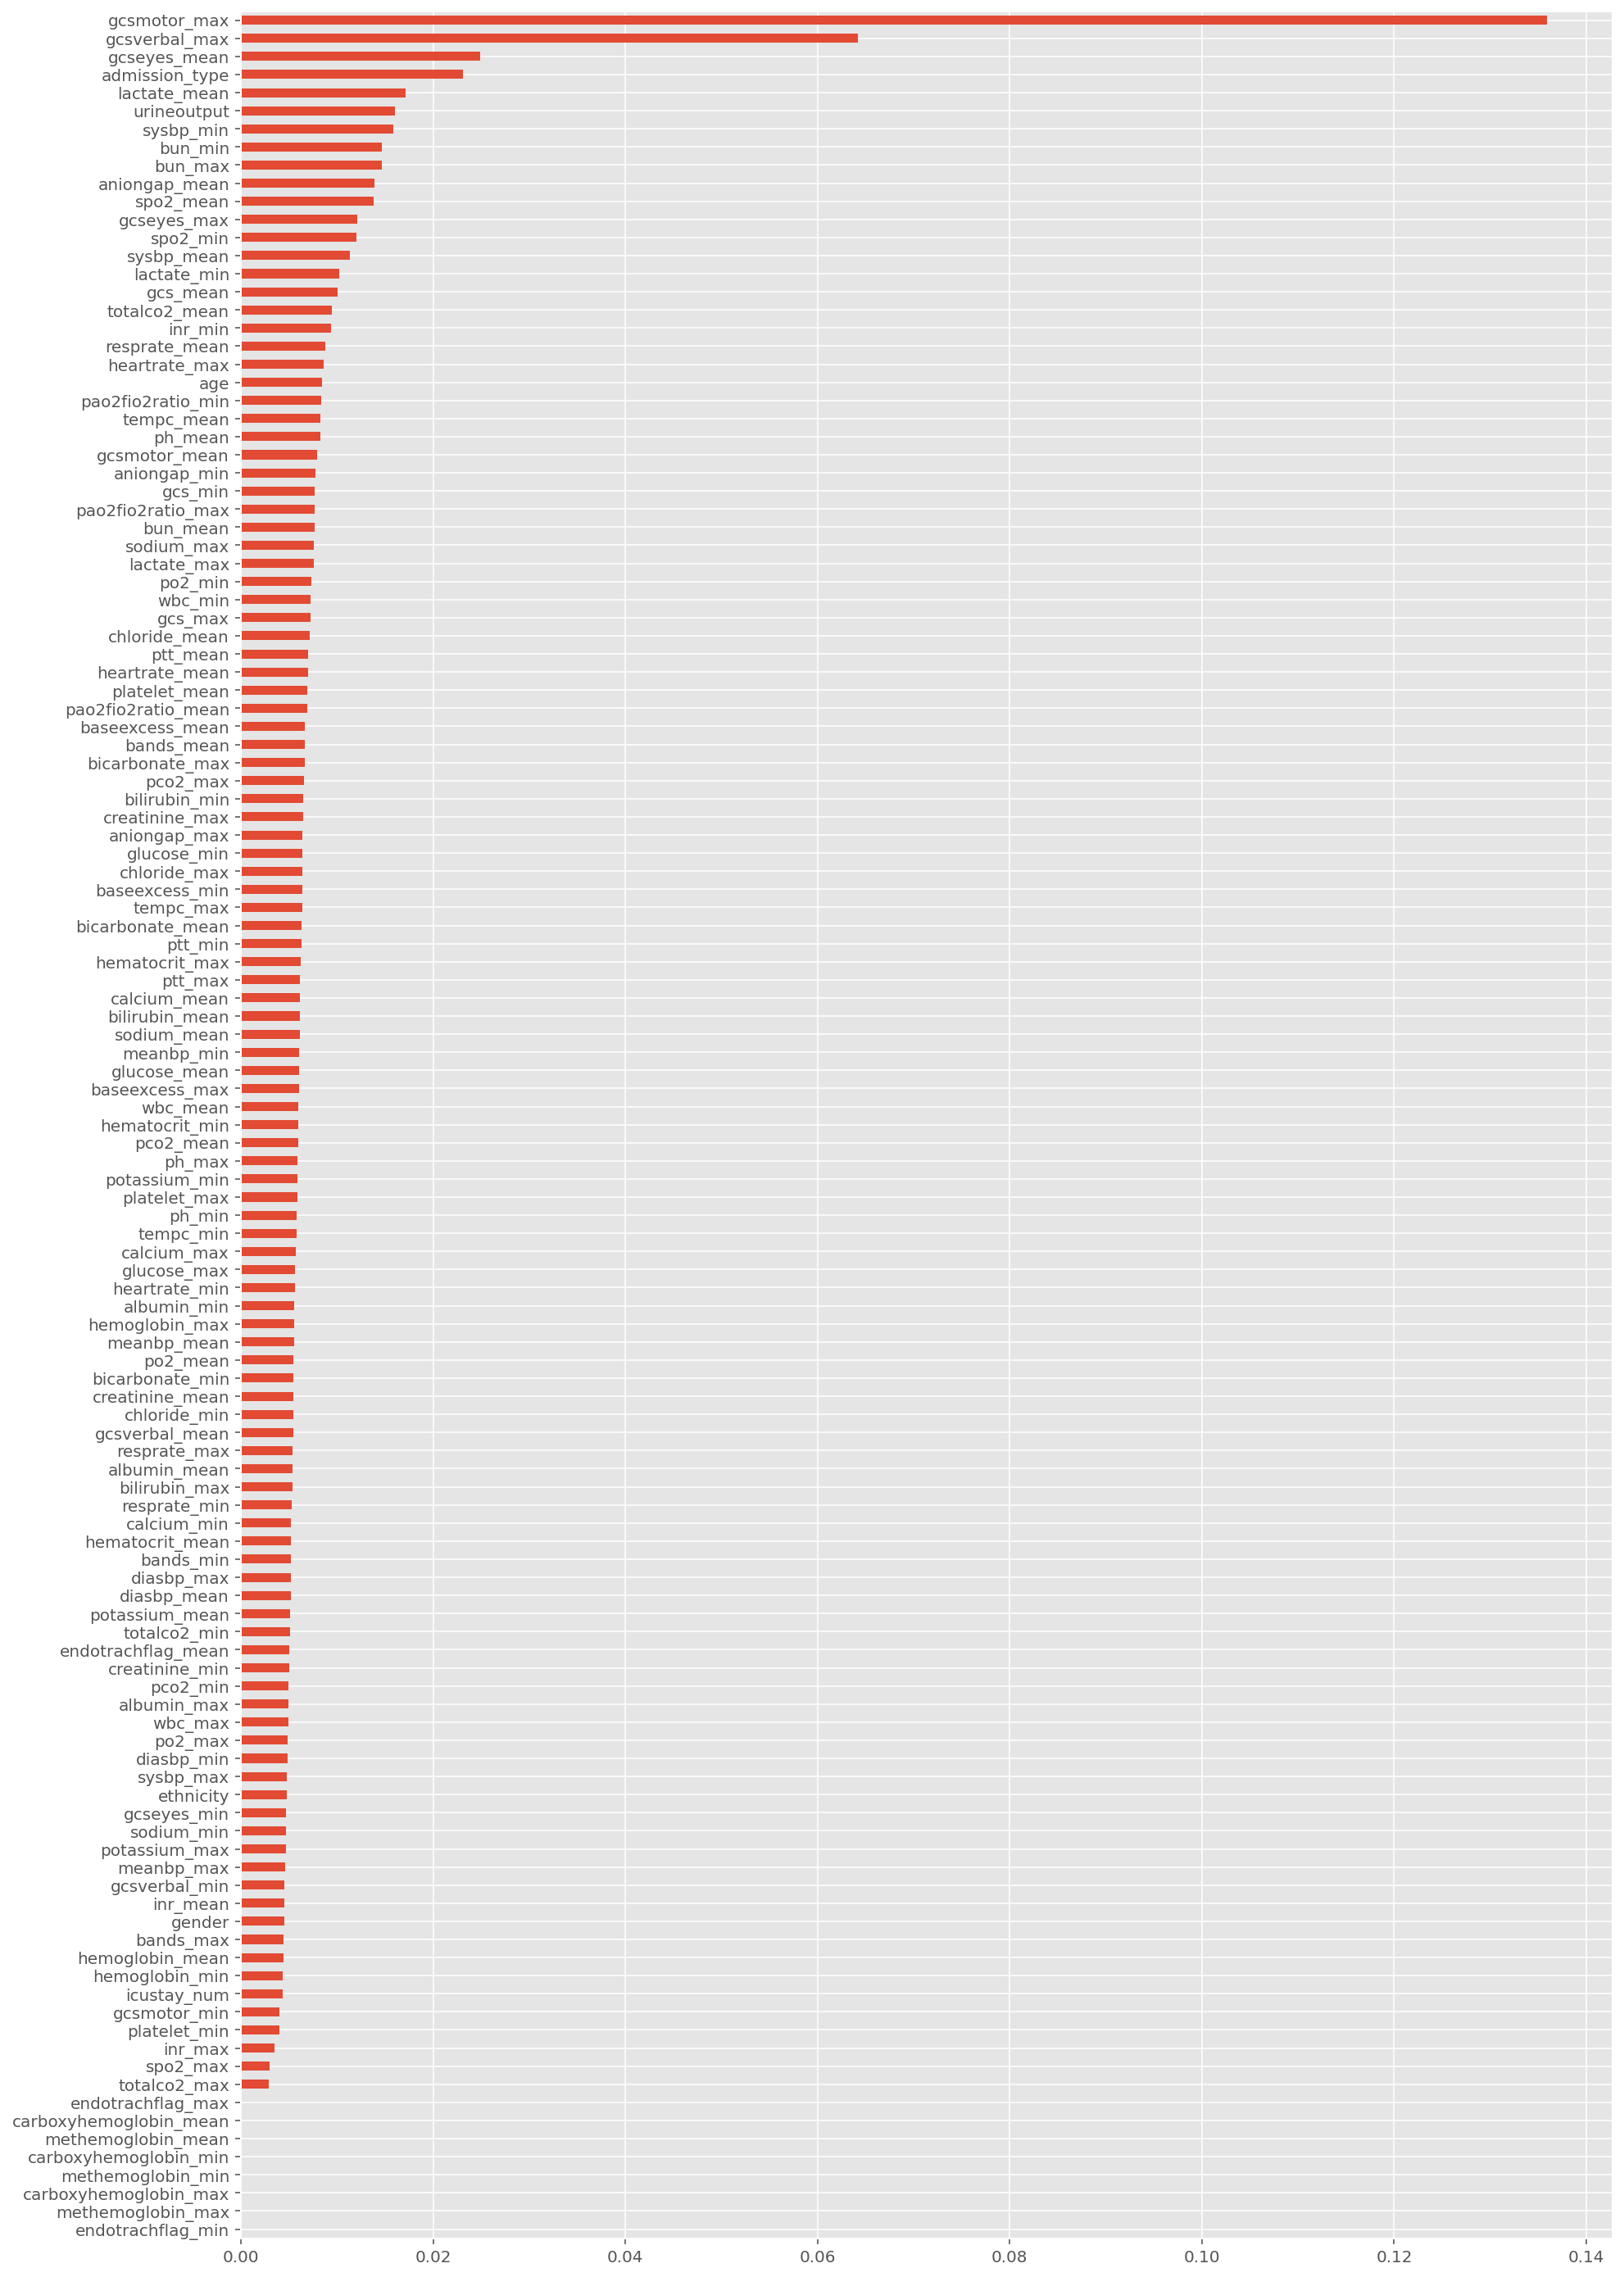

In [15]:
# plot feature importance
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(15,25)
    
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
print("Top 10 features")
print(feat_importances.nlargest(10))

feat_importances.nsmallest(123).plot(kind='barh')

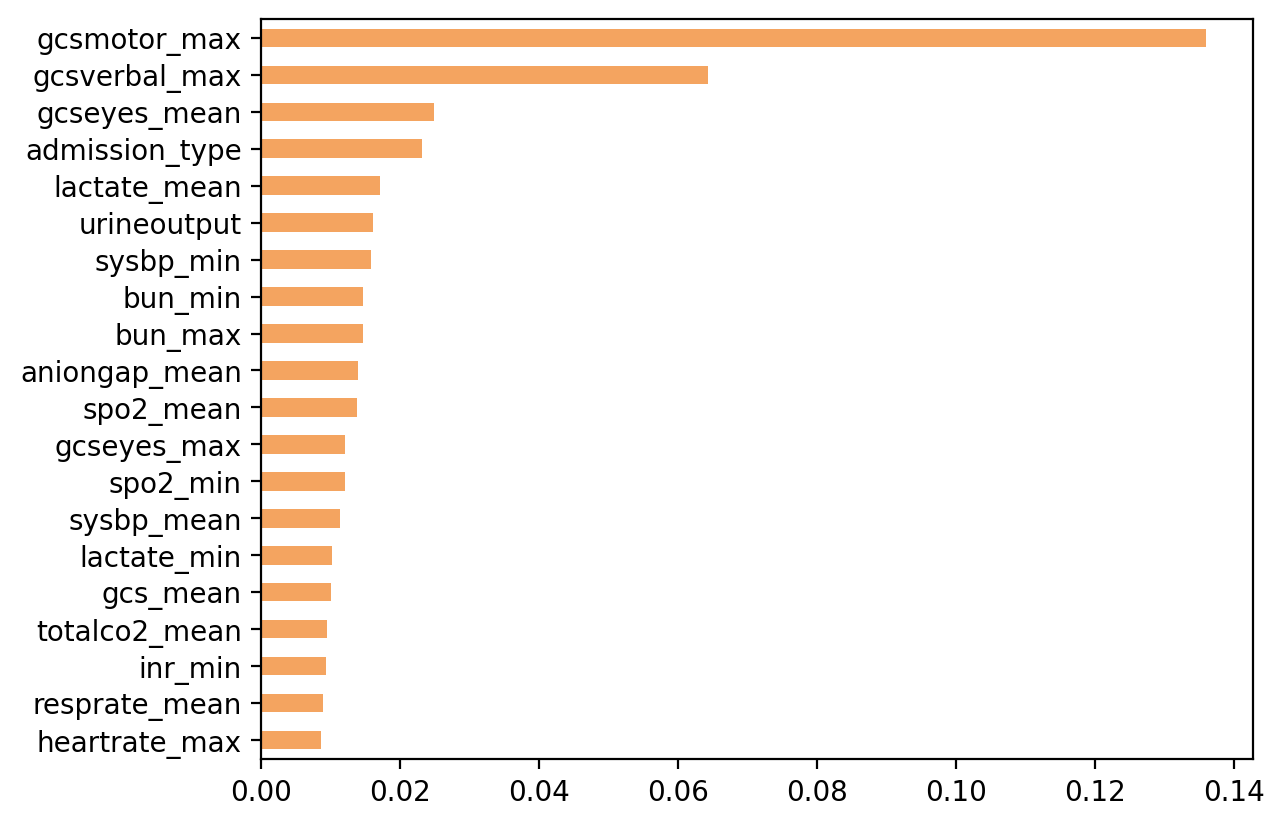

In [16]:
# plot top 20 feature importance
plt.style.use('default')
fig.set_size_inches(15,10)
fig = plt.figure()
feat_importances.nlargest(20).sort_values(ascending=True).plot(kind='barh', color='sandybrown')
fig.savefig('../img/figure7.png', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [17]:
# Models
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

models = dict()
#models['Dicision Tree'] = DecisionTreeClassifier(class_weight={0:1,1:2})
models['Random Forest'] = RandomForestClassifier(class_weight={0:1,1:2})
models['Logistic Regression'] = LogisticRegression()
#models['Ridge Regression'] = Ridge(alpha=1.0)
models['GradientBoost'] = GradientBoostingClassifier()
models['AdaBoost'] = AdaBoostClassifier()
models['XGBoost'] = xgboost.XGBClassifier()
models['GaussianNB']= GaussianNB(var_smoothing = 1e-9)
models['KNN'] = KNeighborsClassifier(n_neighbors=3)
models['MLP'] = MLPClassifier()

In [18]:
for model in models:
    models[model].fit(X_train, y_train)
    print(model + ' : fit')

Random Forest : fit


D:\software\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression : fit
GradientBoost : fit
AdaBoost : fit
[21:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\software\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoost : fit
GaussianNB : fit
KNN : fit
MLP : fit


In [19]:
print("Train set prediction")
for x in models:
        
    print('------------------------'+x+'------------------------')
    model = models[x]
    y_train_pred = model.predict(X_train)  # X_train, X_test, y_train, y_test
    arg_train = {'y_true':y_train, 'y_pred':y_train_pred}
    print(confusion_matrix(**arg_train))
    print(classification_report(**arg_train))

Train set prediction
------------------------Random Forest------------------------
[[  724     0     0]
 [    0  2041     0]
 [    0     0 36940]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       724
           1       1.00      1.00      1.00      2041
           2       1.00      1.00      1.00     36940

    accuracy                           1.00     39705
   macro avg       1.00      1.00      1.00     39705
weighted avg       1.00      1.00      1.00     39705

------------------------Logistic Regression------------------------
[[  143    54   527]
 [   23    81  1937]
 [   13    80 36847]]
              precision    recall  f1-score   support

           0       0.80      0.20      0.32       724
           1       0.38      0.04      0.07      2041
           2       0.94      1.00      0.97     36940

    accuracy                           0.93     39705
   macro avg       0.70      0.41      0.45     39705
weighted avg  

In [20]:
print("Test set prediction")
for x in models:
        
    print('------------------------'+x+'------------------------')
    model = models[x]
    y_test_pred = model.predict(X_test)
    arg_test = {'y_true':y_test, 'y_pred':y_test_pred}
    print(confusion_matrix(**arg_test))
    print(classification_report(**arg_test))

Test set prediction
------------------------Random Forest------------------------
[[  76    8   78]
 [  17   31  428]
 [   4   17 9268]]
              precision    recall  f1-score   support

           0       0.78      0.47      0.59       162
           1       0.55      0.07      0.12       476
           2       0.95      1.00      0.97      9289

    accuracy                           0.94      9927
   macro avg       0.76      0.51      0.56      9927
weighted avg       0.93      0.94      0.93      9927

------------------------Logistic Regression------------------------
[[  38   16  108]
 [   5   17  454]
 [   5   22 9262]]
              precision    recall  f1-score   support

           0       0.79      0.23      0.36       162
           1       0.31      0.04      0.06       476
           2       0.94      1.00      0.97      9289

    accuracy                           0.94      9927
   macro avg       0.68      0.42      0.47      9927
weighted avg       0.91      0.94

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score,mean_squared_error

# no ROC curve for multicalss graph.

In [25]:
print('accuracy_score')
for i in models:
    model = models[i]
    print(i + ' : ',accuracy_score(y_test, model.predict(X_test)).round(4))
    
print('RMSE')
for i in models:
    model = models[i]
    print(i + ' : ',np.sqrt(mean_squared_error(y_test, model.predict(X_test))).round(4))

accuracy_score
Random Forest :  0.9444
Logistic Regression :  0.9386
GradientBoost :  0.9469
AdaBoost :  0.9445
XGBoost :  0.949
GaussianNB :  0.8064
KNN :  0.9309
MLP :  0.9416
RMSE
Random Forest :  0.2835
Logistic Regression :  0.3092
GradientBoost :  0.2646
AdaBoost :  0.2801
XGBoost :  0.2553
GaussianNB :  0.4959
KNN :  0.341
MLP :  0.2977
